# CIFAR10 분류로 살펴보는 1Cycle Policy & Superconvergence

In [1]:
from torchvision import datasets, transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [3]:
trainset = datasets.CIFAR10(root='cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = datasets.CIFAR10(root='cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## ResNet-56

In [4]:
class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

In [5]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [6]:
def find_lr(model, train_dl, epochs=1, start=1e-4, end=8.0, beta=0.95, momentum=0.99, decay=0):
    optimizer = optim.SGD(model.parameters(), lr=start, momentum=momentum, weight_decay=decay)
    avg_loss, best_loss = 0, float('inf')
    step = (end / start) ** (1/(len(train_dl) * epochs - 1))
    i, lr = 1, start
    lr_losses = []
    for _ in range(epochs):
        for data, labels in train_dl:
            input, target = Variable(data).cuda(), Variable(labels).cuda()
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
            smoothed_loss = avg_loss / (1 - beta ** i)
            lr_losses.append((lr, smoothed_loss, loss.data.item()))
            if smoothed_loss > 4 * best_loss:
                return lr_losses
            elif smoothed_loss < best_loss:
                best_loss = smoothed_loss
            loss.backward()
            optimizer.step()
            lr *= step
            optimizer.param_groups[0]['lr'] = lr
            i += 1
    return lr_losses

## Finding Upper Bound of Learning Rate


In [7]:
torch.manual_seed(42)
model = ResNet([9,9,9]).cuda()
lr_losses = find_lr(model, trainloader, epochs=1, start=1e-5, end=1e2, momentum=0.95, decay=1e-4)

/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


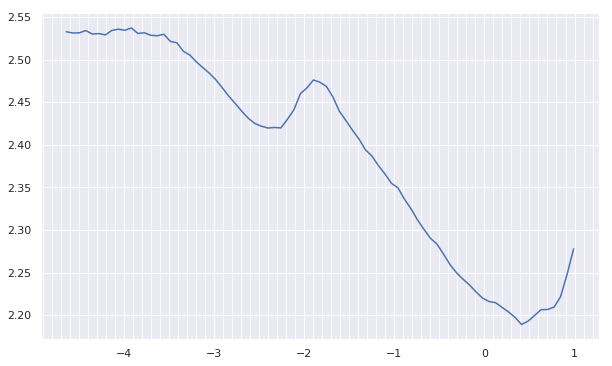

In [8]:
xs, ys = ([math.log10(p[0]) for p in lr_losses[5:-5]], [p[1] for p in lr_losses[5:-5]])
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(math.floor(min(xs)) - 1, math.ceil(max(xs)) + 1, 0.1), minor=True)
ax.set_xticks(np.arange(math.floor(min(xs)) - 1, math.ceil(max(xs)) + 1, 1), minor=False)
ax.grid(which='minor', alpha=0.8)
ax.grid(which='major', alpha=1.0)
ax.plot(xs, ys);

In [9]:
def eval(model, test_dl):
    model.eval()
    num_examples, avg_loss, correct_count = 0, 0, 0
    with torch.no_grad():
        for data, labels in test_dl:
            input = Variable(data).cuda()
            output = model(input)
            loss = F.nll_loss(output, labels.cuda())
            avg_loss += loss.data.item()
            correct_count += np.sum(np.argmax(output.cpu().numpy(), axis=1) == labels.cpu().numpy())
            num_examples += labels.size(0)
        return avg_loss / num_examples, correct_count * 100 / num_examples

In [10]:
def train(model, train_dl, epochs=10, min_lr=0.1, max_lr=1):
    def cyclical_lr(min_lr, max_lr, num_steps, p_tails=0.08, eps=1e-7):
        peak_step = num_steps * (1 - p_tails) // 2
        print(f'steps: {peak_step}')
        def lr_func(step):
            if step <= peak_step:
                return min_lr + (max_lr - min_lr) * (step / peak_step)
            elif step > 2 * peak_step:
                return min_lr - (step - peak_step * 2) * eps
            else:
                return max(1e-18, max_lr - (max_lr - min_lr) * (step - peak_step) / peak_step)
        return lr_func
    optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.95, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, cyclical_lr(min_lr, max_lr, len(train_dl) * epochs))
    avg_losses, accs = [], []
    for _ in range(epochs):
        model.train()
        avg_loss, acc, num_examples = 0, 0, 0
        for data, labels in train_dl:
            input, target = Variable(data).cuda(), Variable(labels).cuda()
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss += loss.data.item()
            acc += np.sum(np.argmax(output.detach().cpu().numpy(), axis=1) == labels.cpu().numpy())
            num_examples += target.size(0)
            scheduler.step()
            loss.backward()
            optimizer.step()
        avg_loss /= num_examples
        acc = acc * 100 / num_examples
        val_avg_loss, val_acc = eval(model, testloader)  # 원래는 validation dataset을 써야 하지만 없어서..
        print(f'Epoch [{_+1:2d}/{epochs:2d}]: learning rate is {optimizer.param_groups[0]["lr"]}')
        print(f'Epoch [{_+1:2d}/{epochs:2d}]: (Train) avg loss {avg_loss:.5f}, accuracy {acc:.3f}%')
        print(f'Epoch [{_+1:2d}/{epochs:2d}]: (Valid) avg loss {val_avg_loss:.5f}, accuracy {val_acc:.3f}%')
        avg_losses.append((avg_loss, val_avg_loss))
        accs.append((acc,val_acc))
    return avg_losses, accs

In [11]:
torch.manual_seed(42)
model = ResNet([9,9,9]).cuda()
l, a = train(model, trainloader, epochs=100, min_lr=0.05, max_lr=5)

steps: 4508.0


/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [ 1/100]: learning rate is 0.15651064773735582
Epoch [ 1/100]: (Train) avg loss 0.00364, accuracy 29.724%
Epoch [ 1/100]: (Valid) avg loss 0.02261, accuracy 30.180%
Epoch [ 2/100]: learning rate is 0.26411934338952975
Epoch [ 2/100]: (Train) avg loss 0.00277, accuracy 47.692%
Epoch [ 2/100]: (Valid) avg loss 0.01564, accuracy 45.420%
Epoch [ 3/100]: learning rate is 0.37172803904170365
Epoch [ 3/100]: (Train) avg loss 0.00224, accuracy 58.896%
Epoch [ 3/100]: (Valid) avg loss 0.01714, accuracy 48.900%
Epoch [ 4/100]: learning rate is 0.47933673469387755
Epoch [ 4/100]: (Train) avg loss 0.00192, accuracy 65.110%
Epoch [ 4/100]: (Valid) avg loss 0.01447, accuracy 54.810%
Epoch [ 5/100]: learning rate is 0.5869454303460515
Epoch [ 5/100]: (Train) avg loss 0.00171, accuracy 69.224%
Epoch [ 5/100]: (Valid) avg loss 0.01085, accuracy 62.790%
Epoch [ 6/100]: learning rate is 0.6945541259982255
Epoch [ 6/100]: (Train) avg loss 0.00156, accuracy 72.514%
Epoch [ 6/100]: (Valid) avg loss 0.

Epoch [50/100]: learning rate is 4.5706632653061225
Epoch [50/100]: (Train) avg loss 0.00203, accuracy 65.130%
Epoch [50/100]: (Valid) avg loss 0.01588, accuracy 49.560%
Epoch [51/100]: learning rate is 4.4630545696539485
Epoch [51/100]: (Train) avg loss 0.00198, accuracy 66.122%
Epoch [51/100]: (Valid) avg loss 0.01644, accuracy 47.680%
Epoch [52/100]: learning rate is 4.3554458740017745
Epoch [52/100]: (Train) avg loss 0.00194, accuracy 66.476%
Epoch [52/100]: (Valid) avg loss 0.02067, accuracy 41.650%
Epoch [53/100]: learning rate is 4.2478371783496005
Epoch [53/100]: (Train) avg loss 0.00200, accuracy 65.912%
Epoch [53/100]: (Valid) avg loss 0.02679, accuracy 39.000%
Epoch [54/100]: learning rate is 4.1402284826974265
Epoch [54/100]: (Train) avg loss 0.00192, accuracy 66.830%
Epoch [54/100]: (Valid) avg loss 0.01730, accuracy 50.800%
Epoch [55/100]: learning rate is 4.0326197870452525
Epoch [55/100]: (Train) avg loss 0.00179, accuracy 68.916%
Epoch [55/100]: (Valid) avg loss 0.0209

Epoch [99/100]: learning rate is 0.049931500000000004
Epoch [99/100]: (Train) avg loss 0.00055, accuracy 90.450%
Epoch [99/100]: (Valid) avg loss 0.00393, accuracy 86.910%
Epoch [100/100]: learning rate is 0.0499217
Epoch [100/100]: (Train) avg loss 0.00054, accuracy 90.304%
Epoch [100/100]: (Valid) avg loss 0.00402, accuracy 86.860%


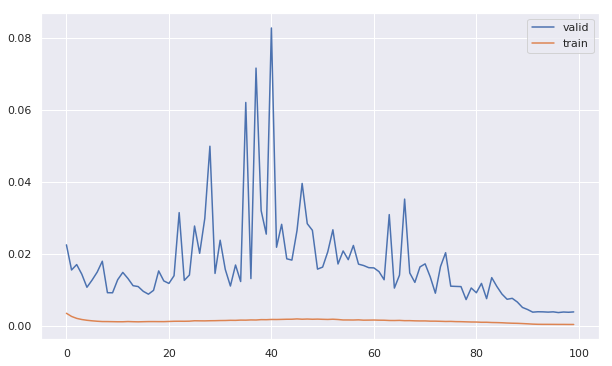

In [14]:
fig = plt.figure(figsize=(10, 6))
xs, ys = (list(range(len(l))), [p[-1] for p in l])
plt.plot(xs, ys)
xs, ys = (list(range(len(l))), [p[0] for p in l])
plt.plot(xs, ys)
plt.legend(['valid', 'train'], ncol=1, loc='upper right');